In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import json
import h5py
import glob
import copy
import pdb

import importlib
import util_neurophysiology
importlib.reload(util_neurophysiology)

import pitchnet_evaluate_best

sys.path.append('ibmHearingAid/multi_gpu')
import functions_graph_assembly as fga

sys.path.append('/om2/user/msaddler/pitchnet/assets_psychophysics')
import util_figures_psychophysics

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_misc
import util_stimuli

import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import IPython.display as ipd


ImportError in `dataset_util.py` No module named 'pyfftw'


In [ ]:
fn = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/NEUROPHYSIOLOGY_v01_bernox2005_activations_tuning_low_harm_f0.hdf5'
# fn = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed0/NEUROPHYSIOLOGY_v01_bernox2005_activations_tuning_low_harm_f0.hdf5'
f = h5py.File(fn, 'r')

for v in f.values():
    print(v)

f.close()


In [ ]:
master_list = [
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', 'Speech + music (arch_0191)'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/', 'Speech + music (arch_0302)'),
    
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + music (natural)'),
#     ('/saved_models/models_sr20000/arch_0302/PNDv08PYSmatched12_TLASmatched12_snr_neg10pos10_phase3_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (matched)'),
#     ('/saved_models/models_sr20000/arch_0302/PNDv08PYSnegated12_TLASmatched12_snr_neg10pos10_phase3_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (anti-matched)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (highpass)'),

#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Trained on highpass synth. tones'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/', 'Trained on speech and music'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (natural)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (bandpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (highpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (bandpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (highpass)'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (low noise)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_posInf_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (no noise)'),
]

# results_basename = 'NEUROPHYSIOLOGY_v01_bernox2005_activations_tuning_low_harm_f0.hdf5'
results_basename = 'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5'

model_keys = []
results_dicts = {}
for model_dir_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    results_fn_regex = os.path.join(model_dir_regex, results_basename)
    for results_fn in sorted(glob.glob(results_fn_regex)):
        with h5py.File(results_fn, 'r') as f:
            key_list = [
                'relu_0',
                'relu_1',
                'relu_2',
                'relu_3',
                'relu_4',
                'relu_fc_intermediate',
            ]
            results_dict = {
                'f0_bins': f['f0_bins'][:],
                'f0_label': f['f0_label'][:],
                'low_harm': f['low_harm'][:],
                'octave_bins': f['octave_bins'][:],
            }
            for k in key_list:
                x = f[k][:]
                unit_max_values = x.max(axis=(1, 2), keepdims=True)
                nzidx = np.squeeze(unit_max_values > 0)
                x[nzidx] = x[nzidx] / unit_max_values[nzidx]

                results_dict[k + '_f0_label'] = np.mean(np.mean(x, axis=1), axis=0)

                idx_best_f0 = np.argmax(np.mean(x, axis=1), axis=1)
                x_low_harm_tuning_at_best_f0 = np.zeros([x.shape[0], x.shape[1]], dtype=x.dtype)
                for idx_unit, idx_f0 in enumerate(idx_best_f0):
                    x_low_harm_tuning_at_best_f0[idx_unit, :] = x[idx_unit, :, idx_f0]
                results_dict[k + '_low_harm'] = np.mean(x_low_harm_tuning_at_best_f0, axis=0)
                
#                 results_dict[k + '_low_harm'] = np.mean(np.mean(x, axis=2), axis=0)
#                 results_dict[k + '_low_harm'] /= results_dict[k + '_low_harm'].max()
                
#                 results_dict[k + '_f0_label'] = np.mean(f[k + '_population_mean'][:], axis=0)
#                 results_dict[k + '_low_harm'] = np.mean(f[k + '_population_mean'][:], axis=1)
#                 print(k + '_f0_label', results_dict[k + '_f0_label'].shape)
#                 print(k + '_low_harm', results_dict[k + '_low_harm'].shape)
                
                octave_tuning = f[k + '_octave_tuning'][:]
                octave_tuning_count = f[k + '_octave_tuning_count'][:]
                unit_max_values = octave_tuning.max(axis=1, keepdims=True)
                nzidx = np.squeeze(unit_max_values > 0)
                octave_tuning[nzidx] = octave_tuning[nzidx] / unit_max_values[nzidx]
                IDX = np.arange(0, octave_tuning.shape[0], 1, dtype=int)
                
                n_subsample = 3168
                np.random.seed(858)
                np.random.shuffle(IDX)
                subsampled_octave_tuning = octave_tuning[IDX[:n_subsample], :]
                subsampled_octave_tuning_count = octave_tuning_count[IDX[:n_subsample], :]
                
                print(subsampled_octave_tuning.shape)
                
                tmp = np.sum(subsampled_octave_tuning, axis=0)
                tmp_count = np.sum(subsampled_octave_tuning_count, axis=0)
                tmp[tmp_count > 0] = tmp[tmp_count > 0] / tmp_count[tmp_count > 0]
                results_dict[k + '_octave_tuning'] = tmp
                
            results_dicts[model_key].append(results_dict)
        
        print(model_key, results_fn)


In [ ]:
importlib.reload(util_neurophysiology)

color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR FILTERING SOUNDS
# color_list = [color_list[idx] for idx in [0, 2, 4]]
color_list = [color_list[0], color_list[-1]]


for cidx, model_key in enumerate(model_keys[1:]):
    fig, ax = plt.subplots(nrows=1,
                           ncols=1,
                           figsize=(4.4, 2.75))
    results_dict_input = results_dicts[model_key]
    kwargs_plot_update = {
        'color': color_list[cidx],
        'label': None}
    ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
        ax,
        results_dict_input,
        kwargs_plot_update=kwargs_plot_update,
#         ylimits=[0, None]
    )
    plt.show()


for cidx, model_key in enumerate(model_keys):
    fig, ax = plt.subplots(nrows=1,
                           ncols=1,
                           figsize=(4.4, 2.75))
    results_dict_input = results_dicts[model_key]
    
    kwargs_plot_update = {
        'color': color_list[cidx],
        'label': None}
    ax, DATA = util_neurophysiology.make_f0_tuning_plot(
        ax,
        results_dict_input,
        kwargs_plot_update=kwargs_plot_update,
#         ylimits=[0, None]
    )
    plt.show()



# for cidx, model_key in enumerate(model_keys):
#     fig, ax = plt.subplots(nrows=1,
#                            ncols=1,
#                            figsize=(4.4, 2.75))
#     results_dict_input = results_dicts[model_key]
#     ax, DATA = util_neurophysiology.make_octave_tuning_plot(
#         ax,
#         results_dict_input,
#         key_resp_list=['relu_{}'.format(i) for i in range(5)] + ['relu_fc_intermediate']
#     )
#     plt.show()


In [ ]:
importlib.reload(util_neurophysiology)

list_key_layer = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
#     'relu_fc_intermediate',
]

ncols = len(list_key_layer)
nrows = 1
gridspec_kw = {
    'wspace': 0.15,
}
fig, ax_arr = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(2.2*ncols, 2*nrows),
                           gridspec_kw=gridspec_kw)

for idx_layer, key_layer in enumerate(list_key_layer):
    results_dict_input = results_dicts[model_keys[0]]
    kwargs_plot_update = {'color': 'k', 'label': None}
    util_neurophysiology.make_octave_tuning_plot(ax_arr[idx_layer],
                                                 results_dict_input,
                                                 key_resp_list=key_layer,
                                                 kwargs_plot_update=kwargs_plot_update,
                                                 xlimits=[-1.2, 1.2],
                                                 ylimits=[0, 1.1],
                                                 str_title='conv {}'.format(idx_layer+1),
                                                 fontsize_title=16,
                                                 fontweight_title='bold',
                                                 yticks=np.arange(0, 1.01, 0.2),
                                                 yticks_minor=np.arange(0, 1.01, 0.2),
                                                 xticks=[-1, 0, 1],
                                                 xticklabels=['-1', '0', '+1'],
                                                 xticks_minor=np.arange(-1.2, 1.21, 0.2))
    if idx_layer > 0:
        ax_arr[idx_layer].set_ylabel(None)
        ax_arr[idx_layer].set_yticks([])
    
    if not idx_layer == 2:
        ax_arr[idx_layer].set_xlabel(None)

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_octave_tuning_arch0191_natural_speech_music.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


In [ ]:
model_keys

In [ ]:
importlib.reload(util_neurophysiology)
color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR FILTERING SOUNDS
color_list = [color_list[idx] for idx in [0, 2, 4]]
color_list = ['k', color_list[-1]]

figsize = (2.5, 2)
xlimits=[0, 16]
xticks=np.arange(0, 17, 5)
xticks_minor=np.arange(0, 17, 1)

SUPER_DATA_DICT = {}
label_list = [
    'natural_speech_music',
    'anti_matched_synthetic'
]
for cidx, model_key in enumerate(model_keys):
    fig, ax = plt.subplots(nrows=1,
                           ncols=1,
                           figsize=figsize)
    results_dict_input = results_dicts[model_key]
    kwargs_plot_update = {
        'color': color_list[cidx],
        'label': None,
    }
    ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
        ax,
        results_dict_input,
        key_resp_list=['relu_0', 'relu_1', 'relu_2', 'relu_3', 'relu_4'],
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update={'fontsize': 11},
        xlimits=xlimits,
        xticks=xticks,
        xticks_minor=xticks_minor,
    )
    plt.show()
    
    MODEL_KEY = label_list[cidx] + '-bernox2005'
    if MODEL_KEY in SUPER_DATA_DICT:
        SUPER_DATA_DICT[MODEL_KEY] = util_misc.recursive_dict_merge(SUPER_DATA_DICT[MODEL_KEY], DATA)
    else:
        SUPER_DATA_DICT[MODEL_KEY] = DATA

#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_low_harm_tuning_arch0191_{}.pdf'.format(label_list[cidx]))
#     fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
#     print(save_fn)



fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=figsize)
ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
    ax,
    util_neurophysiology.get_results_dict_norman_haignere_2013(),
    xlimits=xlimits,
    xticks=xticks,
    xticks_minor=xticks_minor,
    str_ylabel='% Signal change\n(relative to silence)',
    kwargs_legend_update={'loc': 'lower right', 'handlelength': 0}
)
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_low_harm_tuning_normanhaignere2013.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)



fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=figsize)
ax, DATA = util_neurophysiology.make_low_harm_tuning_plot(
    ax,
    util_neurophysiology.get_results_dict_bendor_and_wang_2005(),
    xlimits=xlimits,
    xticks=xticks,
    xticks_minor=xticks_minor,
    str_ylabel='Discharge rate\n(normalized)'
)
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_low_harm_tuning_bendorwang2005.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


# for k1 in SUPER_DATA_DICT.keys():
#     print(k1)
#     for k2 in SUPER_DATA_DICT[k1].keys():
#         print('\t', k2, SUPER_DATA_DICT[k1][k2].shape)
# print('<><><> [BEGIN] WRITING SUPER_DATA_DICT TO JSON FILE <><><>')
# with open('tmp.json', 'w') as f:
#     json.dump(SUPER_DATA_DICT, f, sort_keys=True, cls=util_misc.NumpyEncoder)
# print('<><><> [END] WRITING SUPER_DATA_DICT TO JSON FILE <><><>')


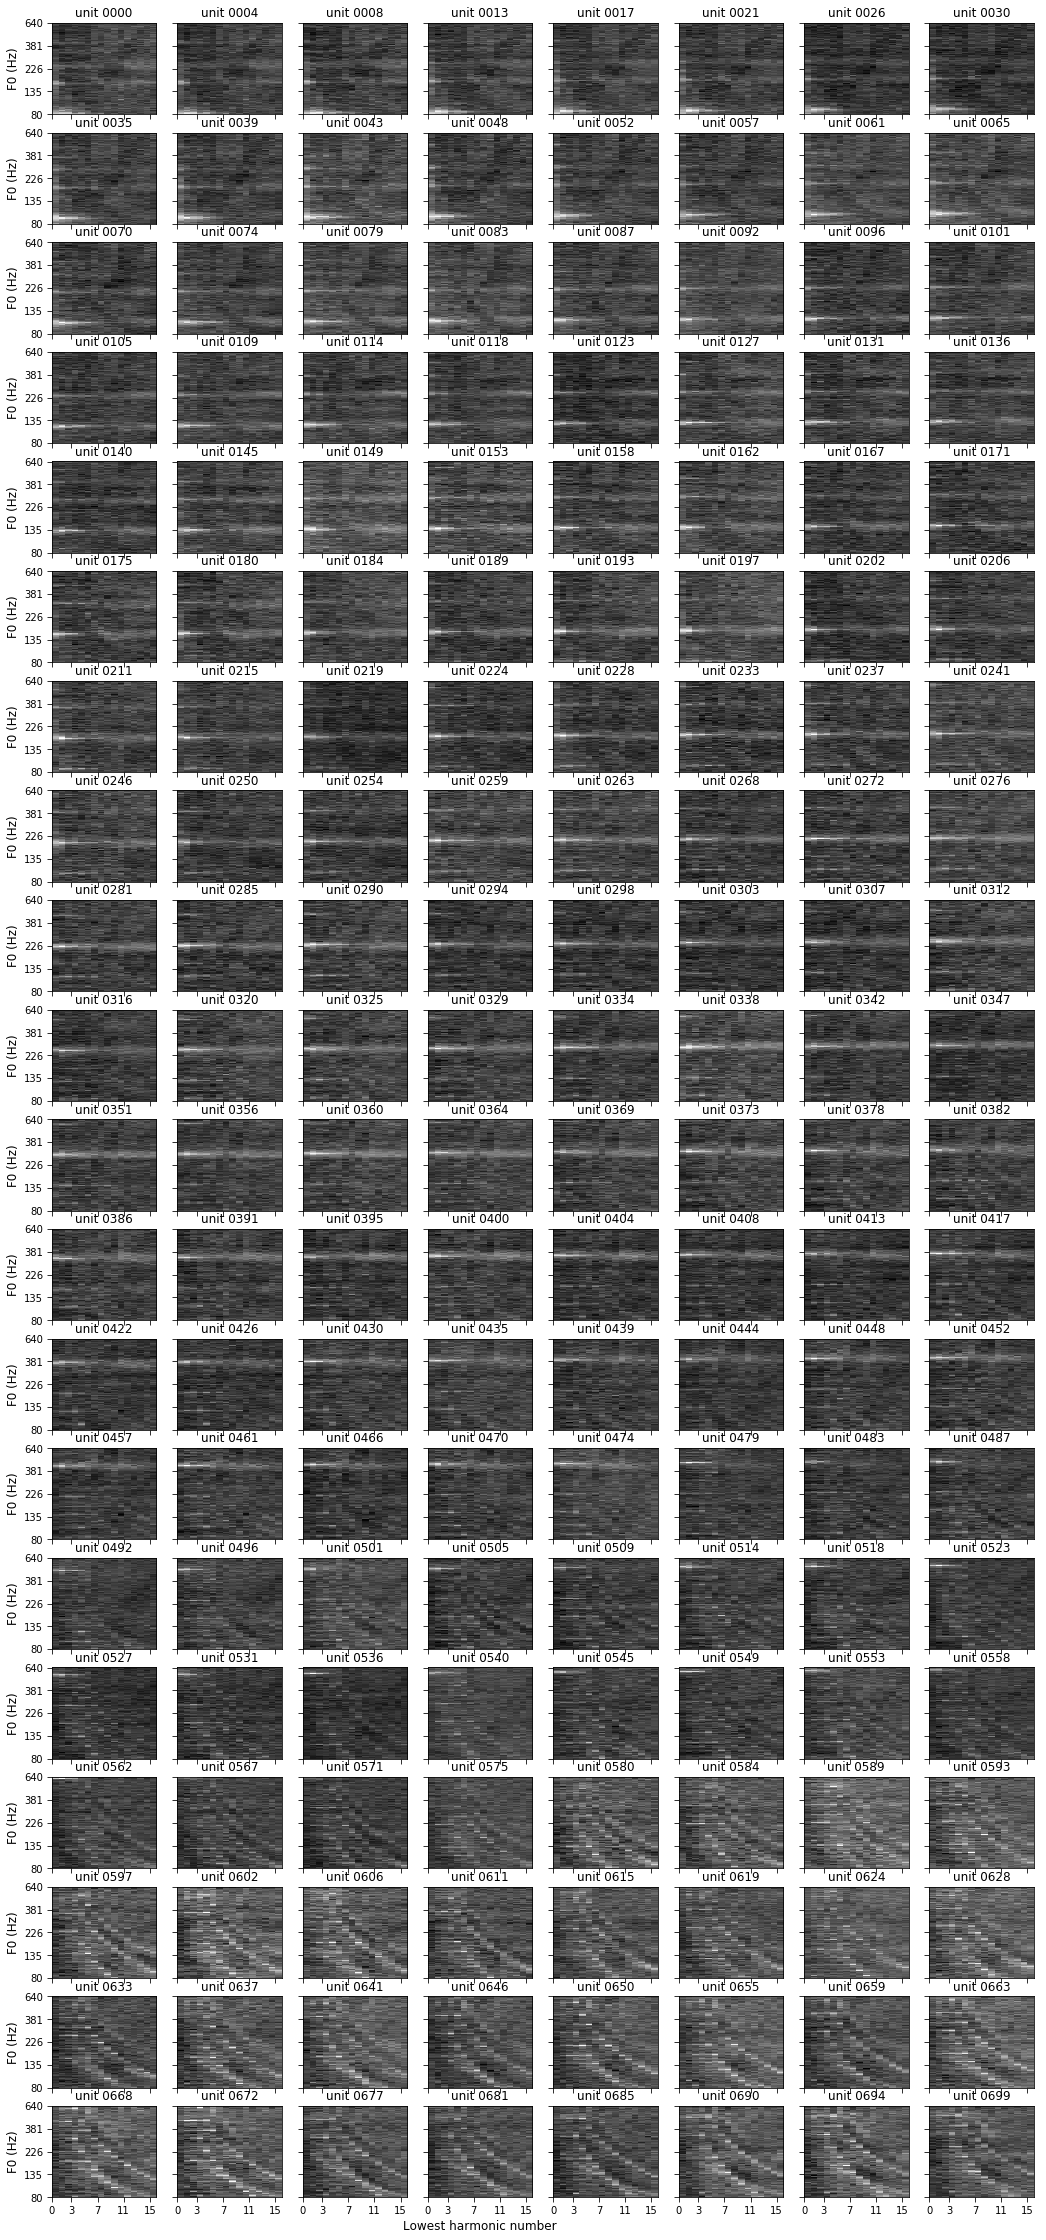

In [2]:
importlib.reload(util_neurophysiology)

# model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/'
model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/'
# model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed0/'
# results_basename = 'NEUROPHYSIOLOGY_v01_bernox2005_activations_tuning_low_harm_f0.hdf5'
results_basename = 'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5'

fn = os.path.join(model_dir, results_basename)
np.random.seed(858)

# list_unit_idx = sorted([4537, 4605, 6750, 2952, 5802]) # Five selected from 15 randomly drawn with random seed 858
list_unit_idx = [2225, 2914, 3069, 3642, 4605] # Five selected from 45 randomly drawn with random seed 858
nrows=1
ncols=5

list_unit_idx = sorted(list(np.random.randint(0, 4608, [160])))
list_unit_idx = sorted(list(np.random.randint(0, 3168, [160])))
list_unit_idx = np.linspace(0, 699, 160, dtype=int)

nrows=9+11
ncols=5+3

with h5py.File(fn, 'r') as f:
    figsize=(2.2*ncols, 2.0*nrows)
    fontsize_ticks = 10
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)#, constrained_layout=True)
    ax = np.array(ax).reshape([nrows, ncols])
    itr0 = 0
    for r_idx in range(nrows):
        for c_idx in range(ncols):
            kwargs_make_2d_tuning_plot = {
                'str_xlabel': None,
                'str_ylabel': 'F0 (Hz)',
            }
            if r_idx < nrows - 1:
                kwargs_make_2d_tuning_plot['str_xlabel'] = None
                kwargs_make_2d_tuning_plot['xticklabels'] = []
            if c_idx > 0:
                kwargs_make_2d_tuning_plot['str_ylabel'] = None
                kwargs_make_2d_tuning_plot['yticklabels'] = []
            if (c_idx == np.ceil(ncols/2) - 1) and (r_idx == nrows - 1):
                kwargs_make_2d_tuning_plot['str_xlabel'] = 'Lowest harmonic number'
            ax[r_idx, c_idx], IMG = util_neurophysiology.make_2d_tuning_plot(
                ax[r_idx, c_idx],
                f,
                key_act='fc_top',
                unit_idx=list_unit_idx[itr0],
                fontsize_ticks=fontsize_ticks,
                **kwargs_make_2d_tuning_plot)
            itr0 += 1
    
#     cbar = fig.colorbar(IMG,
#                         ax=ax,
#                         aspect=10,
#                         pad=0.02,
#                         orientation='vertical')
#     cbar.set_label('Activation\n(normalized)', fontsize=12, labelpad=6)
#     cbar.ax.tick_params(labelsize=fontsize_ticks, length=fontsize_ticks/4)
    plt.show()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_unit_tuning_examples_arch0191_natural_speech_music.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)

fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0)


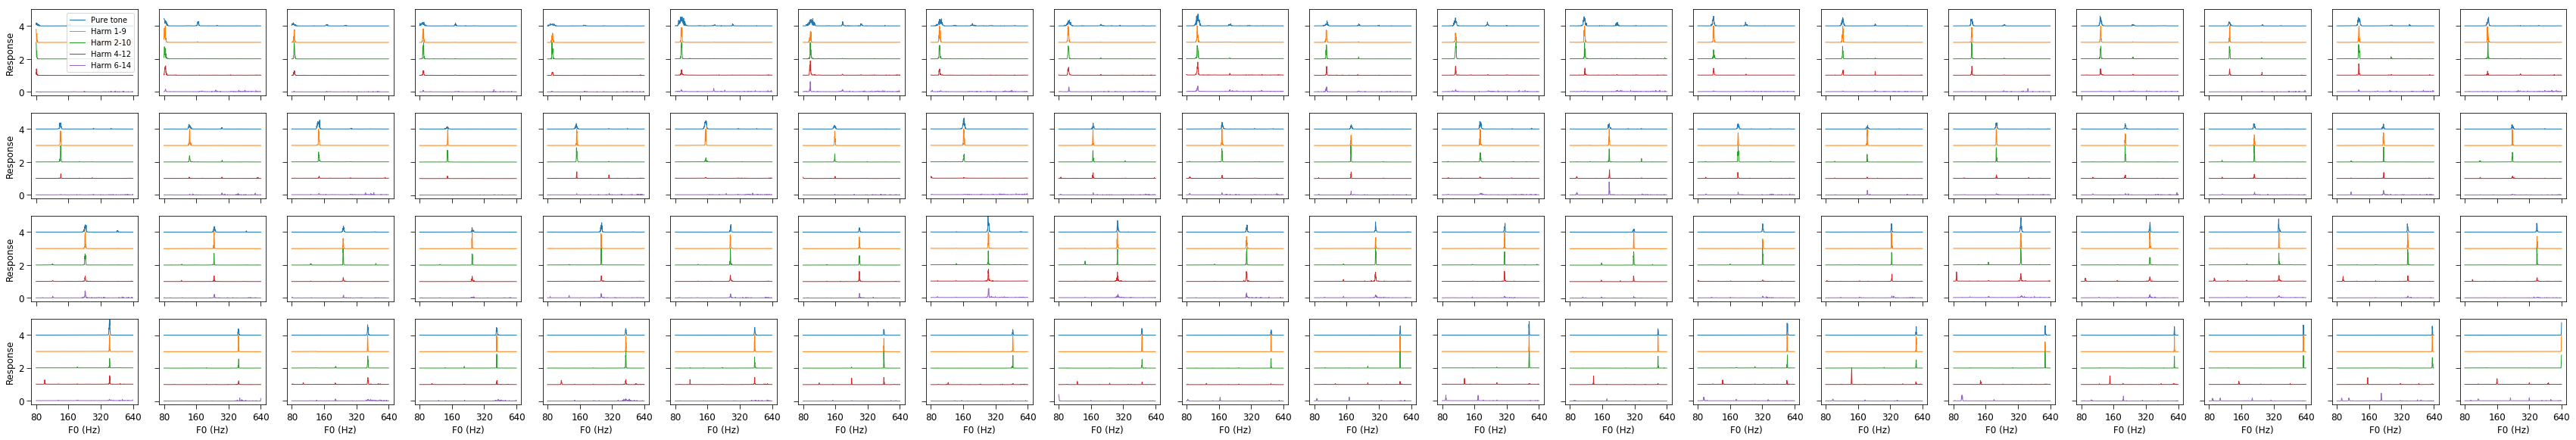

In [47]:
importlib.reload(util_neurophysiology)

model_dir = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/'
results_basename = 'NEUROPHYSIOLOGY_v02_bernox2005_activations_tuning_low_harm_f0.hdf5'

fn = os.path.join(model_dir, results_basename)
np.random.seed(858)
layer_name = 'fc_top_softmax'
nrows=4
ncols=20
if 'fc_top' in layer_name:
    list_unit_idx = np.linspace(0, 576, nrows * ncols, dtype=int)
else:
    list_unit_idx = sorted(list(np.random.randint(0, 3168, nrows * ncols)))
list_low_harm = [0, 1, 2, 4, 6]

with h5py.File(fn, 'r') as f:
    figsize=(3.0*ncols, 2.4*nrows)
    fontsize_ticks = 10
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)#, constrained_layout=True)
    ax = np.array(ax).reshape([nrows, ncols])
    itr0 = 0
    for r_idx in range(nrows):
        for c_idx in range(ncols):
            tuning_array = f[layer_name][list_unit_idx[itr0]]
            low_harm = f['low_harm'][:]
            f0_label = f['f0_label'][:]
            
            xval = f['f0_label']
            xval_labels = f['f0_bins']
            xtick_indexes = np.linspace(xval[0], xval[-1], 4, dtype=int)
            xticks = [xval[xti] for xti in xtick_indexes]
            xticklabels = ['{:.0f}'.format(xval_labels[xti]) for xti in xtick_indexes]
            
            for itr_lh, lh in enumerate(list_low_harm):
                tuning_curve = np.squeeze(tuning_array[low_harm == lh])
                if tuning_curve.max() > 0:
                    tuning_curve = tuning_curve / tuning_array.max()
                if lh == 0:
                    label = 'Pure tone'
                else:
                    label = 'Harm {}-{}'.format(lh, lh + 9 - 1)
                ax[r_idx, c_idx].plot(f0_label, tuning_curve + len(list_low_harm)-1-itr_lh, lw=1, label=label)
            kwargs_format_axes = {
                'str_xlabel': 'F0 (Hz)',
                'str_ylabel': 'Response',
                'xticks': xticks,
                'xticklabels': xticklabels,
                'ylimits': [None, len(list_low_harm)],
            }
            if r_idx < nrows - 1:
                kwargs_format_axes['str_xlabel'] = None
                kwargs_format_axes['xticklabels'] = []
            if c_idx > 0:
                kwargs_format_axes['str_ylabel'] = None
                kwargs_format_axes['yticklabels'] = []
            if (c_idx == np.ceil(ncols/2) - 1) and (r_idx == nrows - 1):
                kwargs_format_axes['str_xlabel'] = 'F0 (Hz)'
            ax[r_idx, c_idx] = util_figures.format_axes(ax[r_idx, c_idx], **kwargs_format_axes)
            if (r_idx == 0) and (c_idx == 0):
                ax[r_idx, c_idx].legend()
            itr0 += 1
    plt.show()


# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0)


In [ ]:
for k in results_dict_input[0].keys():
    print(k, results_dict_input[0][k].shape)

results_dict_input[0]['relu_4_f0_label']


In [ ]:
list_values = list_low_harm
# list_values = list_f0
unique_values = np.unique(list_values)
population_1d_tuning = {
    k: np.zeros_like(unique_values, dtype=np.float32) for k in sorted(population_responses.keys())
}
for itr0, val in enumerate(unique_values):
    IDX = list_values == val
    for k in sorted(population_responses.keys()):
        population_1d_tuning[k][itr0] = np.mean(population_responses[k][IDX])

plt.figure()
for k in sorted(population_1d_tuning.keys()):
    y = population_1d_tuning[k]
    y -= y.min()
    y /= y.max()
    plt.plot(unique_values, y, label=k)
plt.legend()
plt.show()

    

In [ ]:
# Load results_dict, remove extraneous data, and save minimal version
# results_dict_fn_regex = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification[7-8]/NEUROPHYSIOLOGY_bernox2005.json'

# for results_dict_fn in sorted(glob.glob(results_dict_fn_regex)):
#     minimal_results_dict_fn = results_dict_fn.replace('.json', '_minimal.json')
#     print('\nREADING: {}'.format(results_dict_fn))
#     with open(results_dict_fn) as f:
#         results_dict = json.load(f)
#     results_dict.pop('relu_fc_intermediate')
#     for key_layer in sorted(results_dict.keys()):
#         tuning_dict_keys = sorted(results_dict[key_layer].keys())
#         for key_tuning in tuning_dict_keys:
#             if 'low_harm_f0_label' in key_tuning:
#                 results_dict[key_layer].pop(key_tuning)
    
#     with open(minimal_results_dict_fn, 'w') as f:
#         json.dump(results_dict, f, cls=util_misc.NumpyEncoder, sort_keys=True)
#     print('WROTE: {}\n'.format(minimal_results_dict_fn))


In [ ]:
master_list = [
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Trained on natural sounds'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Trained on highpass synth. tones'),

    ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/', 'Trained on speech and music'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (natural)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (bandpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (highpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (bandpass)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/', 'Synthetic tones (highpass)'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (low noise)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_posInf_AN_BW10eN1_IHC3000Hz_classification*/', 'Speech + Music (no noise)'),
]
experiment_basename = 'NEUROPHYSIOLOGY_bernox2005.json'
# experiment_basename = 'NEUROPHYSIOLOGY_bernox2005_minimal.json'
# experiment_basename = 'NEUROPHYSIOLOGY_valid_minimal.json'

model_keys = []
results_dicts = {}
for model_dir_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    results_dict_fn_regex = os.path.join(model_dir_regex, experiment_basename)
    for results_dict_fn in sorted(glob.glob(results_dict_fn_regex)):
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))
        print(model_key, results_dict_fn)


In [ ]:
x = np.array(results_dicts[model_key][0]['relu_4']['low_harm_f0_label_tuning_n'])
np.sum(x) / 512 / 384


In [ ]:
importlib.reload(util_neurophysiology)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
color_list = util_figures.get_color_list(8, 'Accent')
for cidx, model_key in enumerate(model_keys):    
    yval_list = []
    results_dict_input = results_dicts[model_key]
    kwargs_plot_update = {'color': color_list[cidx], 'label': model_key}
    ax = util_neurophysiology.make_low_harm_tuning_plot(ax,
        results_dict_input,
        restrict_conditions=['relu_4'],
        kwargs_plot_update=kwargs_plot_update)
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
color_list = util_figures.get_color_list(8, 'Accent')
for cidx, model_key in enumerate(model_keys):    
    yval_list = []
    results_dict_input = results_dicts[model_key]
    kwargs_plot_update = {'color': color_list[cidx], 'label': model_key}
    ax = util_neurophysiology.make_f0_tuning_plot(ax,
        results_dict_input,
        restrict_conditions=['relu_4'],
        kwargs_plot_update=kwargs_plot_update)
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
color_list = util_figures.get_color_list(8, 'Accent')
for cidx, model_key in enumerate(model_keys):    
    yval_list = []
    results_dict_input = results_dicts[model_key]
    kwargs_plot_update = {'color': color_list[cidx], 'label': model_key}
    ax = util_neurophysiology.make_octave_tuning_plot(ax,
        results_dict_input,
        restrict_conditions=['relu_4'],
        n_subsample=32,
        kwargs_plot_update=kwargs_plot_update)
plt.show()


In [ ]:
importlib.reload(util_neurophysiology)

list_key_layer = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
]

ncols = len(list_key_layer)
nrows = 3
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
color_list = util_figures.get_color_list(8, 'Accent')

for idx_layer, key_layer in enumerate(list_key_layer):
    
    for cidx, model_key in enumerate(model_keys):    
        yval_list = []
        results_dict_input = results_dicts[model_key]
        kwargs_plot_update = {'color': color_list[cidx], 'label': model_key}
        if idx_layer > 0:
            kwargs_plot_update['label'] = None
        
        util_neurophysiology.make_octave_tuning_plot(ax_arr[0, idx_layer],
            results_dict_input,
            restrict_conditions=[key_layer],
            n_subsample=32,
            kwargs_plot_update=kwargs_plot_update)
        
        util_neurophysiology.make_f0_tuning_plot(ax_arr[1, idx_layer],
            results_dict_input,
            restrict_conditions=[key_layer],
            kwargs_plot_update=kwargs_plot_update)
        
        if 'low_harm' in results_dict_input[0][key_layer]:
            util_neurophysiology.make_low_harm_tuning_plot(ax_arr[2, idx_layer],
                results_dict_input,
                restrict_conditions=[key_layer],
                kwargs_plot_update=kwargs_plot_update)

plt.tight_layout()
plt.show()

fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0)


In [ ]:
importlib.reload(util_neurophysiology)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
for cidx, model_key in enumerate(model_keys[0:1]):
    print(model_key)
    yval_list = []
    results_dict_input = results_dicts[model_key]
    restrict_conditions=['relu_0', 'relu_1', 'relu_2', 'relu_3', 'relu_4']
    ax = util_neurophysiology.make_octave_tuning_plot(ax, results_dict_input, restrict_conditions=restrict_conditions)

plt.show()


In [ ]:
importlib.reload(util_neurophysiology)

list_key_layer = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
#     'relu_fc_intermediate',
]

ncols = len(list_key_layer)
nrows = 1
gridspec_kw = {
    'wspace': 0.15,
}
fig, ax_arr = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(2.2*ncols, 2*nrows),
                           gridspec_kw=gridspec_kw)

for idx_layer, key_layer in enumerate(list_key_layer):
    results_dict_input = results_dicts[model_keys[0]]
    kwargs_plot_update = {'color': 'k', 'label': None}
    util_neurophysiology.make_octave_tuning_plot(ax_arr[idx_layer],
                                                 results_dict_input,
                                                 restrict_conditions=[key_layer],
                                                 n_subsample=32,
                                                 kwargs_plot_update=kwargs_plot_update,
                                                 xlimits=[-1.2, 1.2],
                                                 ylimits=[0, 1.1],
                                                 str_title='conv {}'.format(idx_layer+1),
                                                 fontsize_title=16,
                                                 fontweight_title='bold',
                                                 yticks=np.arange(0, 1.01, 0.2),
                                                 yticks_minor=np.arange(0, 1.01, 0.2),
                                                 xticks=[-1, 0, 1],
                                                 xticklabels=['-1', '0', '+1'],
                                                 xticks_minor=np.arange(-1.2, 1.21, 0.2))
    if idx_layer > 0:
        ax_arr[idx_layer].set_ylabel(None)
        ax_arr[idx_layer].set_yticks([])
    
    if not idx_layer == 2:
        ax_arr[idx_layer].set_xlabel(None)

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_octave_tuning_arch0302_natural.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


In [ ]:
importlib.reload(util_neurophysiology)

# Show 2d tuning plots for example units (selected for PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0)
np.random.seed(998)
fontsize_ticks = 10
list_unit_idx = [38, 110, 312, 337, 440]# 285, 393, 454, 440, 433]

for model_key in sorted(results_dicts.keys()):
    print(model_key, len(results_dicts[model_key]))
    
    nrows=1#3
    ncols=len(list_unit_idx)#2
#     figsize=(2.7*ncols, 2.2*nrows)
    figsize=(2.2*ncols, 2.0*nrows)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)#, constrained_layout=True)
    ax = np.array(ax).reshape([nrows, ncols])
    itr0 = 0
    for r_idx in range(nrows):
        for c_idx in range(ncols):
            unit_idx = list_unit_idx[itr0]
            kwargs_make_2d_tuning_plot = {
                'str_xlabel': None,
                'str_ylabel': 'F0 (Hz)',
                'str_title': 'unit {:03d}'.format(unit_idx),
            }
            if r_idx < nrows - 1:
                kwargs_make_2d_tuning_plot['str_xlabel'] = None
                kwargs_make_2d_tuning_plot['xticklabels'] = []
            if c_idx > 0:
                kwargs_make_2d_tuning_plot['str_ylabel'] = None
                kwargs_make_2d_tuning_plot['yticklabels'] = []
            if (c_idx == np.ceil(ncols/2) - 1) and (r_idx == nrows - 1):
                kwargs_make_2d_tuning_plot['str_xlabel'] = 'Lowest harmonic number'
            ax[r_idx, c_idx], IMG = util_neurophysiology.make_2d_tuning_plot(
                ax[r_idx, c_idx],
                results_dicts[model_key][0],
                unit_idx=unit_idx,
                fontsize_ticks=fontsize_ticks,
                **kwargs_make_2d_tuning_plot)
            itr0 += 1
    
    cbar = fig.colorbar(IMG,
                        ax=ax,#[1,:],
#                         aspect=10,
                        pad=0.02,
#                         shrink=1/3,
                        orientation='vertical')
    cbar.set_label('Activation\n(normalized)', fontsize=12, labelpad=6)
    cbar.ax.tick_params(labelsize=fontsize_ticks, length=fontsize_ticks/4)
    
    plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/'
# save_fn = os.path.join(save_dir, 'neurophysiology_bernox2005_unit_tuning_examples_arch0302_natural.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


In [ ]:
importlib.reload(util_neurophysiology)

plt.ioff()

model_key = 'Trained on speech and music'
model_idx = 0
key_act = 'relu_4'
N = 64

ncols=8
nrows=N//ncols
figsize=(2.7*ncols, 2.2*nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
ax = np.array(ax)

itr0 = 512
for r_idx in range(nrows):
    for c_idx in range(ncols):
        if itr0 % 8 == 0: print(itr0, r_idx, c_idx)
        kwargs_make_2d_tuning_plot = {
            'str_xlabel': 'Lowest harmonic\nnumber',
            'str_ylabel': 'F0 (Hz)',
            'str_title': itr0,
        }
        if r_idx < nrows - 1:
            kwargs_make_2d_tuning_plot['str_xlabel'] = None
            kwargs_make_2d_tuning_plot['xticklabels'] = []
        if c_idx > 0:
            kwargs_make_2d_tuning_plot['str_ylabel'] = None
            kwargs_make_2d_tuning_plot['yticklabels'] = []
        img = util_neurophysiology.make_2d_tuning_plot(
            ax[r_idx, c_idx],
            results_dicts[model_key][model_idx],
            unit_idx = itr0,
            **kwargs_make_2d_tuning_plot)
        itr0 += 1

# cbar = fig.colorbar(img,
#                     ax=ax[1,:],
#                     aspect=10,
#                     pad=0.006,
# #                         shrink=1/3,
#                     orientation='vertical')
# cbar.set_label('Activation\n(normalized)', fontsize=12, labelpad=6)
# cbar.ax.tick_params(labelsize=12, length=12/4)

# save_fn = 'tmp{:03d}.pdf'.format(itr0)
# print('SAVING: {}'.format(save_fn))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print('SAVED: {}'.format(save_fn))

# plt.show()


In [ ]:
for k0 in results_dict.keys():
    for k1 in results_dict[k0].keys():
        print(k0, k1, results_dict[k0][k1].shape)

# mask = output_dict['phase_mode'] == 0
# for key in output_dict.keys():
#     output_dict[key] = output_dict[key][mask]

# sort_idx = np.argsort(output_dict['f0'])
# for key in output_dict.keys():
#     output_dict[key] = output_dict[key][sort_idx]
#     print(key, output_dict[key].shape)
    
# for k in sorted(brain_container.keys()):
#     print(k)


In [ ]:
importlib.reload(util_neurophysiology)

tuning_dict = util_neurophysiology.compute_f0_tuning_re_best(output_dict, key_act='relu_3')
for k in sorted(tuning_dict.keys()):
    print(k, tuning_dict[k].shape, tuning_dict[k].max(), tuning_dict[k].min())


In [ ]:
list_key_act = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_5',
    'relu_6',
    'relu_7',
#     'relu_fc_intermediate',
#     'fc_top',
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

for key_act in list_key_act:
    if key_act in output_dict.keys():
        tuning_dict = results_dict[key_act]
        ax.plot(tuning_dict['low_harm_bins'],
                np.mean(tuning_dict['low_harm_tuning_mean'], axis=1),
                marker='.',
                label=key_act)


kwargs_legend = {
    'loc': 'upper right',
    'ncol': 1,
    'frameon': False,
    'fontsize': 12,
    'handlelength': 0.5,
    'borderpad': 0.5,
    'borderaxespad': 0.1,
}
leg = ax.legend(**kwargs_legend)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

ax = util_figures.format_axes(ax,
                             str_xlabel='Lowest harmonic number',
                             str_ylabel='Activation (normalized)',
                             fontsize_labels=12,
                             fontsize_ticks=12,
                             fontweight_labels=None,
                             xscale='linear',
                             yscale='linear',
                             xlimits=None,
                             ylimits=[0, 1],
                             xticks=None,
                             yticks=None,
                             xticks_minor=None,
                             yticks_minor=None,
                             xticklabels=None,
                             yticklabels=None,
                             spines_to_hide=[],
                             major_tick_params_kwargs_update={},
                             minor_tick_params_kwargs_update={})

plt.show()


In [ ]:
list_key_act = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_5',
    'relu_6',
    'relu_7',
    'fc_top',
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

for key_act in list_key_act:
    if key_act in output_dict.keys():
        tuning_dict = results_dict[key_act]
        ax.plot(tuning_dict['octave_bins'],
                np.mean(tuning_dict['octave_tuning_mean'][:, 0:32], axis=1),
                label=key_act)

kwargs_legend = {
    'loc': 'upper right',
    'ncol': 1,
    'frameon': False,
    'fontsize': 12,
    'handlelength': 0.5,
    'borderpad': 0.5,
    'borderaxespad': 0.1,
}
leg = ax.legend(**kwargs_legend)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

ax = util_figures.format_axes(ax,
                             str_xlabel='Octaves above best F0',
                             str_ylabel='Activation (normalized)',
                             fontsize_labels=12,
                             fontsize_ticks=12,
                             fontweight_labels=None,
                             xscale='linear',
                             yscale='linear',
                             xlimits=None,
                             ylimits=[0, 1],
                             xticks=None,
                             yticks=None,
                             xticks_minor=None,
                             yticks_minor=None,
                             xticklabels=None,
                             yticklabels=None,
                             spines_to_hide=[],
                             major_tick_params_kwargs_update={},
                             minor_tick_params_kwargs_update={})

plt.show()


In [ ]:
list_key_act = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_5',
    'relu_6',
    'relu_7',
    'fc_top',
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

for key_act in list_key_act:
    if key_act in output_dict.keys():
        tuning_dict = results_dict[key_act]
        ax.plot(tuning_dict['f0_bins'],
                np.mean(tuning_dict['f0_label_tuning_mean'], axis=1),
                marker='.',
                label=key_act)

kwargs_legend = {
    'loc': 'upper right',
    'ncol': 1,
    'frameon': False,
    'fontsize': 12,
    'handlelength': 0.5,
    'borderpad': 0.5,
    'borderaxespad': 0.1,
}
leg = ax.legend(**kwargs_legend)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

ax = util_figures.format_axes(ax,
                             str_xlabel='F0 (Hz)',
                             str_ylabel='Activation (normalized)',
                             fontsize_labels=12,
                             fontsize_ticks=12,
                             fontweight_labels=None,
                             xscale='log',
                             yscale='linear',
                             xlimits=[80, 320],
                             ylimits=[0, 1],
                             xticks=[100, 200, 300],
                             yticks=None,
                             xticks_minor=np.arange(80, 321, 10),
                             yticks_minor=None,
                             xticklabels=[100, 200, 300],
                             yticklabels=None,
                             spines_to_hide=[],
                             major_tick_params_kwargs_update={},
                             minor_tick_params_kwargs_update={})

plt.show()


In [ ]:
tuning_tensor = results_dict['relu_4']['low_harm_f0_label_tuning_mean']
print(tuning_tensor.shape)

n_subsample = 32
np.random.seed(0)
if n_subsample is not None:
    IDX = np.arange(0, tuning_tensor.shape[-1], 1, dtype=int)
    np.random.shuffle(IDX)
    tuning_tensor = tuning_tensor[:, :, IDX[:n_subsample]]
N = tuning_tensor.shape[-1]

f0_bin_values = tuning_dict['f0_label_bins']
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(tuning_dict['f0_label_bins'][idx]) for idx in f0_idx]

low_harm_values = tuning_dict['low_harm_bins']
low_harm_idx = np.linspace(2, low_harm_values.shape[0]-3, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(tuning_dict['low_harm_bins'][idx]) for idx in low_harm_idx]


NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()

for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].imshow(Z,
                   origin='lower',
                   aspect='auto',
                   extent=[0, Z.shape[1], 0, Z.shape[0]],
                   vmin=0,
                   vmax=1
                  )
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    if idx % NCOLS == 0:
        ax[idx].set_yticks(f0_idx)
        ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)
    
#     ax[idx].plot(f0_bin_values, np.mean(Z, axis=1))
#     ax[idx].set_xticks(f0_idx)
#     ax[idx].set_xticklabels(f0_labels)
#     ax[idx].set_yticks([0, 1])
    
#     ax[idx].plot(low_harm_values, np.mean(Z, axis=0))
#     ax[idx].set_xticks(low_harm_idx)
#     ax[idx].set_xticklabels(low_harm_labels)
#     ax[idx].set_yticks([0, 1])

plt.tight_layout()
plt.show()


In [ ]:
### CELLS BELOW CONTAIN REFERENCES TO DEPRECATED FUNCTIONS (KEPT FOR LEGACY PURPOSES ONLY) ###

In [ ]:
importlib.reload(util_neurophysiology)

f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3)
output_dict['f0_label'] = dataset_util.f0_to_label(output_dict['f0'], f0_bins)

key_act_list = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc_intermediate',
]

for unit_idx in [0, 1, 2, 3]:
    NCOLS = len(key_act_list)
    NROWS = 1
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.0*NCOLS, 3.0*NROWS))
    ax = np.array(ax).flatten()

    for idx, key_act in enumerate(key_act_list):
        tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act=key_act, normalize_act=False)

        f0_bin_values = [f0_bins[idx] for idx in np.unique(output_dict['f0_label'])]
        f0_bin_values = np.array(f0_bin_values)
        f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=5, dtype=int)
        f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

        low_harm_values = np.unique(output_dict['low_harm'])
        low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=5, dtype=int)
        low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

        Z = tuning_tensor[unit_idx, :, :].T

        str_title = '{}: unit {}'.format(key_act, unit_idx)
        ax[idx].set_title(str_title, fontsize=12)
        ax[idx].imshow(Z,
                       origin='lower',
                       aspect='auto',
                       extent=[0, Z.shape[1], 0, Z.shape[0]],
                       cmap=plt.cm.gray)
        ax[idx] = util_figures.format_axes(ax[idx],
                                            str_xlabel='Lowest harmonic',
                                            str_ylabel='F0 (Hz)',
                                            fontsize_labels=12,
                                            fontsize_ticks=12,
                                            fontweight_labels=None,
                                            xscale='linear',
                                            yscale='linear',
                                            xlimits=None,
                                            ylimits=None,
                                            xticks=low_harm_idx,
                                            yticks=f0_idx,
                                            xticks_minor=None,
                                            yticks_minor=None,
                                            xticklabels=low_harm_labels,
                                            yticklabels=f0_labels,
                                            spines_to_hide=[],
                                            major_tick_params_kwargs_update={},
                                            minor_tick_params_kwargs_update={})

    plt.tight_layout()
    plt.show()


In [ ]:
importlib.reload(util_neurophysiology)

f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3)
output_dict['f0']
output_dict['f0_label'] = dataset_util.f0_to_label(output_dict['f0'], f0_bins)

key_act_list = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc_intermediate',
]

NCOLS = len(key_act_list)
NROWS = 2
gridspec_kw = {
    'wspace': 0.5,
    'hspace': 0.1,
    'height_ratios': [1, 5],
}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.0*NCOLS, 3.0), gridspec_kw=gridspec_kw, sharex=True, sharey=False)

for idx, key_act in enumerate(key_act_list):
    tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act=key_act, normalize_act=False)

    f0_bin_values = [f0_bins[idx] for idx in np.unique(output_dict['f0_label'])]
    f0_bin_values = np.array(f0_bin_values)
    f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

    low_harm_values = np.unique(output_dict['low_harm'])
    low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=5, dtype=int)
    low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]
    
    Z = np.mean(tuning_tensor, axis=0).T
    ax[0, idx].plot(np.mean(Z, axis=0), color='k', lw='2')
    ax[1, idx].imshow(Z,
                   origin='lower',
                   aspect='auto',
                   extent=[0, Z.shape[1], 0, Z.shape[0]],
                   cmap=plt.cm.gray)
    ax[1, idx] = util_figures.format_axes(ax[1, idx],
                                        str_xlabel='Lowest harmonic',
                                        str_ylabel='F0 (Hz)',
                                        fontsize_labels=12,
                                        fontsize_ticks=12,
                                        fontweight_labels=None,
                                        xscale='linear',
                                        yscale='linear',
                                        xlimits=None,
                                        ylimits=None,
                                        xticks=low_harm_idx,
                                        yticks=f0_idx,
                                        xticks_minor=None,
                                        yticks_minor=None,
                                        xticklabels=low_harm_labels,
                                        yticklabels=f0_labels,
                                        spines_to_hide=[],
                                        major_tick_params_kwargs_update={},
                                        minor_tick_params_kwargs_update={})

plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(util_neurophysiology)

kwargs_octave_bins = {
    'octave_min': -3,
    'octave_max': 3,
    'num_bins': 2*4*12*4+1,
}

condition_dict = {
    'relu_0': {'key_act': 'relu_0', 'shuffle': False, 'n_subsample': 32},
    'relu_1': {'key_act': 'relu_1', 'shuffle': False, 'n_subsample': 32},
    'relu_2': {'key_act': 'relu_2', 'shuffle': False, 'n_subsample': 32},
    'relu_3': {'key_act': 'relu_3', 'shuffle': False, 'n_subsample': 32},
    'relu_4': {'key_act': 'relu_4', 'shuffle': False, 'n_subsample': 32},
    'relu_fc': {'key_act': 'relu_fc_intermediate', 'shuffle': False, 'n_subsample': 32},
}

results_dicts = {}

for key in sorted(condition_dict.keys()):
    print(key, condition_dict[key])
    oct_bins, oct_array = util_neurophysiology.compute_octave_tuning_array(output_dict,
                                                      kwargs_octave_bins=kwargs_octave_bins,
                                                      **condition_dict[key])
    oct_array_mean_bins, oct_array_mean, oct_array_err = util_neurophysiology.average_tuning_array(oct_bins, 
                                                                                                   oct_array,
                                                                                                   normalize=True)
    results_dicts[key] = {
        'oct_bins': oct_bins,
        'oct_array': oct_array,
        'oct_array_mean_bins': oct_array_mean_bins,
        'oct_array_mean': oct_array_mean,
        'oct_array_err': oct_array_err,
    }


In [ ]:
key_act_list = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc',
]

COLOR_LIST = util_figures.get_color_list(8, cmap_name='Accent')
# COLOR_LIST = [
#     [0.0] * 3,
#     [0.1] * 3,
#     [0.2] * 3,
#     [0.3] * 3,
#     [0.4] * 3,
# ]

NCOLS = 1
NROWS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4.0*NCOLS, 4.0*NROWS))
ax = np.array(ax).flatten()

xlimits=[-1.25, 1.25]
ylimits=[-0.05, 1.45]

idx = 0
for key_idx, key_act in enumerate(key_act_list):
    rd = results_dicts[key_act]
    xval = rd['oct_array_mean_bins']
    yval = rd['oct_array_mean']
    yerr = rd['oct_array_err'] / np.sqrt(32)
    plot_kwargs = {
        'lw': 3,
        'color': COLOR_LIST[key_idx],
        'label': key_act,
    }
    ax[idx].fill_between(xval, yval-yerr, yval+yerr,
                         alpha=0.50,
                         facecolor=plot_kwargs.get('color', 'k'))
    ax[idx].plot(xval, yval, **plot_kwargs)
    
    kwargs_legend = {
        'loc': 'upper right',
        'frameon': False,
        'fontsize': 12,
        'handlelength': 0.5,
        'borderpad': 0.5,
        'borderaxespad': 0.1,
    }
    leg = ax[idx].legend(**kwargs_legend)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    
    ax[idx] = util_figures.format_axes(ax[idx],
                                        str_xlabel='Octaves above best F0',
                                        str_ylabel='Normalized activation',
                                        fontsize_labels=12,
                                        fontsize_ticks=12,
                                        fontweight_labels=None,
                                        xscale='linear',
                                        yscale='linear',
                                        xlimits=xlimits,
                                        ylimits=ylimits,
                                        xticks=np.arange(-1, 1.01, 0.5),
                                        yticks=None,
                                        xticks_minor=None,
                                        yticks_minor=None,
                                        xticklabels=None,
                                        yticklabels=None,
                                        spines_to_hide=[],
                                        major_tick_params_kwargs_update={},
                                        minor_tick_params_kwargs_update={})

plt.tight_layout()
plt.show()


In [ ]:
num_colors = 10#len(condition_dict.keys())
cmap_name = 'tab10'
COLOR_LIST = util_figures.get_color_list(num_colors, cmap_name=cmap_name)

color_condition_list = [
#     ([0.5]*3, 'control'),
    (0, 'relu_0'),
    (1, 'relu_1'),
    (2, 'relu_2'),
    (3, 'relu_3'),
    (4, 'relu_4'),
]

figsize=(6, 4.5)
fontsize_labels=16
fontsize_legend=13
fontsize_ticks=13

xlimits=[-1.25, 1.25]
ylimits=[-0.05, 1.05]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

for (cidx, key) in color_condition_list:
    rd = results_dicts[key]
    xval = rd['oct_array_mean_bins']
    yval = rd['oct_array_mean']
    yerr = rd['oct_array_err']
    
    if isinstance(cidx, int): color = COLOR_LIST[cidx]
    else: color = cidx
    
#     plot_kwargs = {
#         'lw': 0.1,
#         'color': color,
#         'label': None,
#     }
#     if 'control' not in key:
#         N = rd['oct_array'].shape[1]
#         for itr1 in range(N):
#             tuning_curve = rd['oct_array'][:, itr1]
#             octave_bins = rd['oct_bins']
#             valid_idx = tuning_curve >= 0
#             y = tuning_curve[valid_idx]
#             x = octave_bins[valid_idx]
#             ax.plot(x, y, **plot_kwargs)
    
    plot_kwargs = {
        'lw': 4,
        'color': color,
        'label': key,
    }
    
    ax.fill_between(xval, yval-yerr, yval+yerr,
                    alpha=0.10,
                    facecolor=plot_kwargs.get('color', 'k'))
    ax.plot(xval, yval, **plot_kwargs)
    
legend_plot_kwargs = {
    'loc':'upper right',
    'frameon':False,
    'fontsize':fontsize_legend,
    'handlelength': 0.5,
    'bbox_to_anchor': [1.04, 1.04],
}
ax.legend(**legend_plot_kwargs)

ax.set_xlabel('Octaves above best F0', fontsize=fontsize_labels)
ax.set_ylabel('Normalized activation', fontsize=fontsize_labels)


ax.set_xticks(np.arange(-1, 1.01, 0.5), minor=False)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+0.01, 0.25), minor=True)
# ax.set_yticks(np.arange(0, ylimits[-1]+0.1, yticks), minor=False)
# ax.set_yticks(np.arange(ylimits[0], ylimits[-1]+0.1, 0.1), minor=True)
ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
ax.tick_params(axis='both', which='minor', length=2)
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)


plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/'
# save_fn = os.path.join(save_dir, 'neurophysiology_f0_tuning_relu0relu2relu4_stddev_arch_0302_PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


In [ ]:
def compute_centroids(output_dict,
                      key_act='relu_5',
                      kwargs_f0_bins={},
                      use_argmax=True):
    
    coarse_f0_bins = dataset_util.get_f0_bins(**kwargs_f0_bins)
    output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'],
                                                              coarse_f0_bins)
    tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict,
                                          key_act=key_act,
                                          key_x='low_harm',
                                          key_y='f0_label_coarse')
    
    f0_bin_values = np.array([coarse_f0_bins[idx]
                              for idx in np.unique(output_dict['f0_label_coarse'])])
    lh_bin_values = np.unique(output_dict['low_harm'])
    
    centroid_f0_list = []
    centroid_lh_list = []
    for itr_unit in range(tuning_tensor.shape[0]):
        tuning_array = tuning_tensor[itr_unit, :, :]
        
        if use_argmax:
            ind = np.unravel_index(np.argmax(tuning_array, axis=None), tuning_array.shape)
            centroid_f0 = f0_bin_values[ind[1]]
            centroid_lh = lh_bin_values[ind[0]]
        else:
            weights_f0 = np.mean(tuning_array, axis=0)
            centroid_f0 = np.sum(weights_f0 * f0_bin_values) / np.sum(weights_f0)

            weights_lh = np.mean(tuning_array, axis=1)
            centroid_lh = np.sum(weights_lh * lh_bin_values) / np.sum(weights_lh)
            
        centroid_f0_list.append(centroid_f0)
        centroid_lh_list.append(centroid_lh)
    
    centroid_f0_list = np.array(centroid_f0_list)
    centroid_lh_list = np.array(centroid_lh_list)
    return centroid_f0_list, centroid_lh_list, f0_bin_values, lh_bin_values


kwargs_f0_bins = {'f0_min':80., 'f0_max':1e3, 'binwidth_in_octaves':1/(12*4)}
condition_list = ['relu_0', 'relu_1', 'relu_2', 'relu_3', 'relu_4']
results_dicts = {}
for key in condition_list:
    
    centroid_f0_list, centroid_lh_list, f0_bin_values, lh_bin_values = compute_centroids(
        output_dict, key_act=key, kwargs_f0_bins=kwargs_f0_bins, use_argmax=True)
    
    results_dicts[key] = {
        'f0_bin_values': f0_bin_values,
        'lh_bin_values': lh_bin_values,
        'centroid_f0_list': centroid_f0_list,
        'centroid_lh_list': centroid_lh_list,
        'centroid_f0_indexes': np.digitize(centroid_f0_list, f0_bin_values, right=True),
        'centroid_lh_indexes': np.digitize(centroid_lh_list, lh_bin_values, right=True),
    }


In [ ]:
num_colors = 10#len(condition_dict.keys())
cmap_name = 'tab10'
COLOR_LIST = util_figures.get_color_list(num_colors, cmap_name=cmap_name)

color_condition_list = [
    (0, 'relu_0'),
    (1, 'relu_1'),
    (2, 'relu_2'),
    (3, 'relu_3'),
    (4, 'relu_4'),
]

figsize=(3, 3)
fontsize_labels=12
fontsize_legend=12
fontsize_ticks=12
fontsize_title=12

NCOLS = 1
NROWS = len(color_condition_list)
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(figsize[0]*NCOLS, figsize[1]*NROWS))
ax = ax.flatten()

for ax_idx, (cidx, key) in enumerate(color_condition_list):
    rd = results_dicts[key]
    xidx = rd['centroid_lh_indexes']
    yidx = rd['centroid_f0_indexes']
    xbin = rd['lh_bin_values']
    ybin = rd['f0_bin_values']
    
    plot_kwargs = {
        'color': COLOR_LIST[cidx],
        'marker': '.',
        'ms': 6,
        'ls': '',
    }

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax[ax_idx].plot(xidx, yidx, **plot_kwargs)
    
    ax[ax_idx].set_xlabel('Lowest harmonic', fontsize=fontsize_labels)
    ax[ax_idx].set_ylabel('F0 (Hz)', fontsize=fontsize_labels)
    ax[ax_idx].set_title(key, fontsize=fontsize_title)
    
    lh_idx = np.linspace(0, xbin.shape[0]-2, num=5, dtype=int)
    lh_labels = ['{:.0f}'.format(xbin[idx]) for idx in lh_idx]
    ax[ax_idx].set_xticks(lh_idx)
    ax[ax_idx].set_xticklabels(lh_labels)
    
    f0_idx = np.linspace(0, ybin.shape[0]-1, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(ybin[idx]) for idx in f0_idx]
    ax[ax_idx].set_yticks(f0_idx)
    ax[ax_idx].set_yticklabels(f0_labels)
    
    ax[ax_idx].set_xlim([-1, len(xbin)])
    ax[ax_idx].set_ylim([-1, len(ybin)])
    
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
    
plt.tight_layout()
plt.show()
    
#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_scatterplot_tuning_peaks_arch_0302_PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0_{}.pdf'.format(key))
#     print(save_fn)
#     fig.savefig(save_fn, bbox_inches='tight')




In [ ]:
coarse_f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3, binwidth_in_octaves=1/(12*4))
output_dict['f0']
output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'], coarse_f0_bins)

tuning_tensor = compute_tuning_tensor(output_dict, key_act='relu_1')
print('computed tuning_tensor:', tuning_tensor.shape)

# f0_tuning_array = np.mean(tuning_tensor, axis=0)
# print('computed f0_tuning_array:', f0_tuning_array.shape)

# low_harm_tuning_array = np.mean(tuning_tensor, axis=1)
# print('computed low_harm_tuning_array:', low_harm_tuning_array.shape)

# sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
# sort_idx_low_harm_tuning = np.argsort(np.argmax(low_harm_tuning_array, axis=0))


# tuning_tensor = tuning_tensor[:, :, sort_idx_low_harm_tuning]
# f0_tuning_array = f0_tuning_array[:, sort_idx_low_harm_tuning]
# low_harm_tuning_array = low_harm_tuning_array[:, sort_idx_low_harm_tuning]

In [ ]:
f0_bin_values = np.array([f0_bins[idx]
                          for idx in np.unique(output_dict['f0_label'])])
low_harm_values = np.unique(output_dict['low_harm'])

figsize=(2.6*0.85, 2.4*.85)
fontsize_labels=14
fontsize_legend=13
fontsize_ticks=12

idx_list = [10, 22] # Relu_1
# idx_list = [12, 99] # Relu_3
# idx_list = [340, 508] # Relu_5

for idx in idx_list:
    
    Z = tuning_tensor[idx, :, :].T
    xbin = low_harm_values
    ybin = f0_bin_values


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax.imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]],
               cmap=plt.cm.gray)
        
    ax.set_xlabel('Lowest harm.', fontsize=fontsize_labels)
    ax.set_ylabel('F0 (Hz)', fontsize=fontsize_labels)
    
    lh_idx = np.linspace(0, xbin.shape[0]-2, num=5, dtype=int)
    lh_labels = ['{:.0f}'.format(xbin[idx]) for idx in lh_idx]
    ax.set_xticks(lh_idx)
    ax.set_xticklabels(lh_labels)
    
    f0_idx = np.linspace(0, ybin.shape[0]-1, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(ybin[idx]) for idx in f0_idx]
    ax.set_yticks(f0_idx)
    ax.set_yticklabels(f0_labels)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
    
    plt.tight_layout()
    
#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_relu1_unit{:03d}.pdf'.format(idx))
#     print(save_fn)
#     fig.savefig(save_fn, bbox_inches='tight')

plt.show()



In [ ]:
fn = '/om/user/msaddler/data_pitchnet/neurophysiology/nharm01_lharm01to01_phase0_f0min080_f0max010240_TENlevel10dB_harmlevel45dBSPL/stim.hdf5'
key_list = util_misc.get_hdf5_dataset_key_list(fn)

f = h5py.File(fn, 'r')

for key in key_list:
    if 'config' in key:
        print(key, f[key][0])


In [ ]:
plt.figure(figsize=(12, 2))

y = f['tone_in_noise'][100]
sr = 32000

freq, pxx = util_stimuli.power_spectrum(y, sr)
plt.plot(freq, pxx)

plt.show()



ipd.display(ipd.Audio(y, rate=sr))

util_stimuli.get_bandlimited_power(y, sr, band=[935.0, 1068.1])


In [ ]:
f.close()

In [ ]:
import pdb
import pitchnet_evaluate_best

sys.path.append('ibmHearingAid/multi_gpu')
import functions_graph_assembly as fga


output_directory_list = [
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0', 'Natural'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0', 'Natural (HPv00)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0', 'Synthetic (HPv00)'),

    ('/saved_models/arch_search_v02_topN/cochlearn/arch_0302', 'cochlearn/arch_0302'),
#     ('/saved_models/arch_search_v02_topN/cochlearn_IHC4000Hz/arch_0302', 'cochlearn_IHC4000Hz/arch_0302'),
#     ('/saved_models/arch_search_v02_topN/cochlearn/arch_0191', 'cochlearn/arch_0191'),
#     ('/saved_models/arch_search_v02_topN/cochlearn_IHC4000Hz/arch_0191', 'cochlearn_IHC4000Hz/arch_0191'),
]

model_dict_list = []

for (output_directory, model_name) in output_directory_list:
    config_fn = os.path.join(output_directory, 'config.json')
    validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')
    with open(config_fn) as f: CONFIG = json.load(f)
    ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                                 metric_key='f0_label:accuracy',
                                                                 maximize=True,
                                                                 checkpoint_number_key='step')
    
    ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
    N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
    BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

    tf.reset_default_graph()
    shape = ITERATOR_PARAMS['feature_parsing_dict'][ITERATOR_PARAMS['feature_signal_path']]['shape']
    batch_subbands = tf.placeholder(tf.float32, shape=[None] + shape)
    if len(batch_subbands.shape) == 2:
        batch_subbands = batch_subbands[:, tf.newaxis, :, tf.newaxis]
    batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    brain_var_scope = 'brain_network'
    brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
    restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
    brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
    brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
    brain_variables =  brain_globals + brain_locals
    saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
        sess, brain_variables, output_directory,
        restore_model_path=restore_model_path,
        ckpt_prefix_name=brain_ckpt_prefix_name)
    
    model_dict = {'model_name': model_name}
#     for v in brain_variables:
#         print(v)
    tf_var = brain_variables[0] # conv0 filter kernels
    tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
    tf_var_name = tf_var.name
    model_dict['vars'] = {tf_var_name: tf_var_value}
    model_dict_list.append(model_dict)


In [ ]:
sr = 32e3

fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=(12, 3),
                       sharex=True,
                       sharey=True)

for model_dict in model_dict_list:    
    model_name = model_dict['model_name']
    kernels = model_dict['vars']['brain_network/coch_conv_0/kernel:0']
    list_pxx = []
    for idx in range(kernels.shape[0]):
        fxx, pxx = util_stimuli.power_spectrum(kernels[idx], sr)
        list_pxx.append(pxx)
#         ax.plot(fxx, pxx, lw=1)
    kernels_pxx = np.stack(list_pxx)
    kernels_pxx_mean = np.mean(kernels_pxx, axis=0)
    kernels_pxx_std = np.std(kernels_pxx, axis=0)
    ax.plot(fxx, kernels_pxx_mean, label=model_name, lw=2)

ax = util_figures.format_axes(ax,
                                str_xlabel='Frequency (Hz)',
                                str_ylabel='Mean power spectrum (dB)',
                                fontsize_labels=12,
                                fontsize_ticks=12,
                                fontweight_labels=None,
                                xscale='linear',
                                yscale='linear',
                                xlimits=None,
                                ylimits=None,
                                xticks=None,
                                yticks=None,
                                xticks_minor=None,
                                yticks_minor=None,
                                xticklabels=None,
                                yticklabels=None,
                                spines_to_hide=[],
                                major_tick_params_kwargs_update={},
                                minor_tick_params_kwargs_update={})
ax.set_title('conv0 kernel mean power spectra', fontsize=12)
ax.legend()
plt.show()


In [ ]:
tf_var = brain_variables[0] # conv0 filter kernels
tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
tf_var_name = tf_var.name

sr = 32e3
print(tf_var_name)

N = tf_var_value.shape[0]

NCOLS = 10
NROWS = int(np.ceil(N / NCOLS))

fig, ax = plt.subplots(nrows=NROWS,
                       ncols=NCOLS,
                       figsize=(2.5*NCOLS, 2.5*NROWS),
                       sharex=True,
                       sharey=False)
ax = ax.flatten()
for idx in range(N):
    x = tf_var_value[idx]
    t = 1e3 * np.arange(0, len(x)) / sr
    ax[idx].plot(t, x, 'k-', lw=0.5)
    (str_xlabel, str_ylabel) = (None, None)
    if idx % NCOLS == 0:
        str_ylabel = 'Pa'
    if idx // NCOLS == NROWS - 1:
        str_xlabel = 'Time (ms)'
    ax[idx] = util_figures.format_axes(
        ax[idx],
        str_xlabel=str_xlabel,
        str_ylabel=str_ylabel,
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='linear',
        yscale='linear',
        xlimits=None,
        ylimits=None,
        xticks=None,
        yticks=None,
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=None,
        spines_to_hide=[],
        major_tick_params_kwargs_update={},
        minor_tick_params_kwargs_update={})
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=NROWS,
                       ncols=NCOLS,
                       figsize=(2.5*NCOLS, 2.5*NROWS),
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for idx in range(N):
    x = tf_var_value[idx]
    fxx, pxx = util_stimuli.power_spectrum(x, sr)
    ax[idx].plot(fxx, pxx, 'k-', lw=0.5)
    (str_xlabel, str_ylabel) = (None, None)
    if idx % NCOLS == 0:
        str_ylabel = 'PSD (dB/Hz SPL)'
    if idx // NCOLS == NROWS - 1:
        str_xlabel = 'Frequency (Hz)'
    ax[idx] = util_figures.format_axes(
        ax[idx],
        str_xlabel=str_xlabel,
        str_ylabel=str_ylabel,
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='log',
        yscale='linear',
        xlimits=[10, 10000],
        ylimits=None,
        xticks=None,
        yticks=None,
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=None,
        spines_to_hide=[],
        major_tick_params_kwargs_update={},
        minor_tick_params_kwargs_update={})
plt.tight_layout()
plt.show()


In [2]:
model_dir_regex = '/saved_models/arch_search_v02_topN/cochlearn/arch_0???'
model_dir_list = glob.glob(model_dir_regex)
model_vars_dict = {}

for model_dir in model_dir_list:
    config_fn = os.path.join(model_dir, 'config.json')
    validation_metrics_fn = os.path.join(model_dir, 'validation_metrics.json')
    with open(config_fn) as f:
        CONFIG = json.load(f)
    ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                                 metric_key='f0_label:accuracy',
                                                                 maximize=True,
                                                                 checkpoint_number_key='step')
    ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
    N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
    BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

    tf.reset_default_graph()
    shape = ITERATOR_PARAMS['feature_parsing_dict'][ITERATOR_PARAMS['feature_signal_path']]['shape']
    batch_subbands = tf.placeholder(tf.float32, shape=[None] + shape)
    if len(batch_subbands.shape) == 2:
        batch_subbands = batch_subbands[:, tf.newaxis, :, tf.newaxis]
    batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    brain_var_scope = 'brain_network'
    brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
    restore_model_path = os.path.join(model_dir, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
    brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
    brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
    brain_variables =  brain_globals + brain_locals
    saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
        sess,
        brain_variables,
        model_dir,
        restore_model_path=restore_model_path,
        ckpt_prefix_name=brain_ckpt_prefix_name)
    
    tf_var = brain_variables[0] # conv0 filter kernels
    tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
    tf_var_name = tf_var.name
    model_vars_dict[model_dir] = tf_var_value


Selecting checkpoint 75000 (f0_label:accuracy=0.23124857246875763)
Loading brain network config from /saved_models/arch_search_v02_topN/cochlearn/arch_0083/brain_arch.json
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
ADDING OPS TO 

ADDING OPS TO CHECKPOINTS
[<tf.Tensor 'brain_network/pool_1:0' shape=(?, 25, 90, 128) dtype=float32>, <tf.Tensor 'brain_network/pool_3:0' shape=(?, 4, 7, 256) dtype=float32>, <tf.Tensor 'brain_network/pool_5:0' shape=(?, 2, 4, 1024) dtype=float32>, <tf.Tensor 'brain_network/pool_2:0' shape=(?, 9, 14, 128) dtype=float32>, <tf.Tensor 'brain_network/pool_0:0' shape=(?, 98, 462, 64) dtype=float32>, <tf.Tensor 'brain_network/pool_4:0' shape=(?, 3, 7, 512) dtype=float32>]
### Loading variables from specified checkpoint: /saved_models/arch_search_v02_topN/cochlearn/arch_0288/brain_model.ckpt-30000
INFO:tensorflow:Restoring parameters from /saved_models/arch_search_v02_topN/cochlearn/arch_0288/brain_model.ckpt-30000
Selecting checkpoint 60000 (f0_label:accuracy=0.22496475279331207)
Loading brain network config from /saved_models/arch_search_v02_topN/cochlearn/arch_0302/brain_arch.json
[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 ra

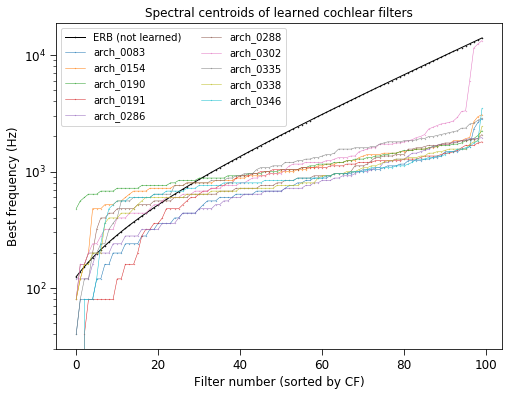

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
list_erb = util_stimuli.erbspace(125, 14e3, 100)
ax.plot(list_erb, 'k.-', lw=1.0, ms=1.0, label='ERB (not learned)')
for model_dir in model_dir_list:
    kernels = model_vars_dict[model_dir]
    list_cf = []

    for itr_kernel in range(kernels.shape[0]):
        fxx, pxx = util_stimuli.power_spectrum(kernels[itr_kernel], 32e3, dBSPL=False)
        pxx_cumsum = np.cumsum(pxx)
        pxx_cumsum = pxx_cumsum / pxx_cumsum[-1]
        cf = fxx[pxx_cumsum >= 0.5][0]
        list_cf.append(cf)
        
    ax.plot(np.sort(list_cf), '.-', lw=0.5, ms=0.5, label=os.path.basename(model_dir))

ax.legend(ncol=2)
ax = util_figures.format_axes(
        ax,
        str_xlabel='Filter number (sorted by CF)',
        str_ylabel='Best frequency (Hz)',
        str_title='Spectral centroids of learned cochlear filters',
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='linear',
        yscale='log',
        xlimits=None,
        ylimits=None,
        xticks=None,
        yticks=None,
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=None,
        spines_to_hide=[],
        major_tick_params_kwargs_update={},
        minor_tick_params_kwargs_update={})
plt.show()
